In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas_datareader.data as web  

In [2]:
# get bank urls
banks = ['JPM/jpmorgan-chase','GS/goldman-sachs','BAC/bank-of-america','C/citigroup','MS/morgan-stanley']
revenue_url = 'https://www.macrotrends.net/stocks/charts/{}/revenue'
roi_url = 'https://www.macrotrends.net/stocks/charts/{}/roi'

def get_url(url):
    urls = []
    for i in banks:
        urls.append(url.format(i))
        
    return urls

get_url(roi_url)

['https://www.macrotrends.net/stocks/charts/JPM/jpmorgan-chase/roi',
 'https://www.macrotrends.net/stocks/charts/GS/goldman-sachs/roi',
 'https://www.macrotrends.net/stocks/charts/BAC/bank-of-america/roi',
 'https://www.macrotrends.net/stocks/charts/C/citigroup/roi',
 'https://www.macrotrends.net/stocks/charts/MS/morgan-stanley/roi']

In [3]:
# get bank revenue df
rev = []
for url, bank in zip(get_url(revenue_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find_all('table')[1]
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df = pd.DataFrame(data, columns=['Date', 'Revenue'])
    df['Bank'] = bank
    rev.append(df)

df_rev = pd.concat(rev, ignore_index=True)


In [4]:
df_rev['Revenue'] = df_rev['Revenue'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)))
df_rev['Date'] = pd.to_datetime(df_rev['Date'])

In [5]:
rev_pivot = df_rev.pivot(index='Date', columns='Bank', values='Revenue')

In [6]:
# df_rev

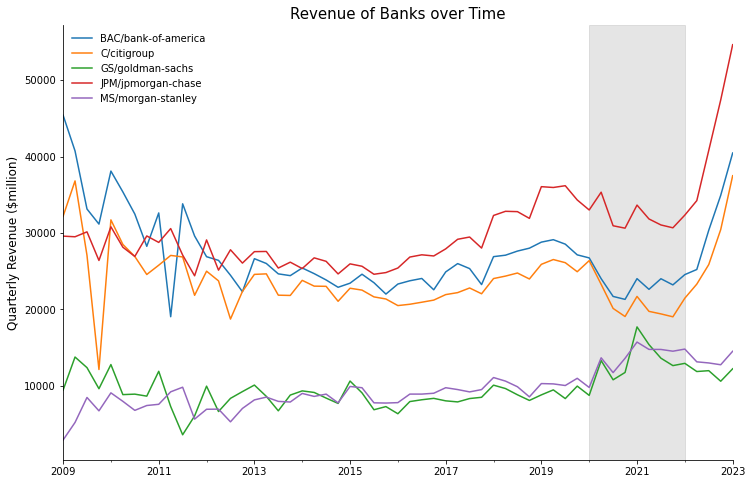

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

rev_pivot.plot(ax=ax)

ax.legend(frameon=False)

ax.set_xlabel('')
ax.set_ylabel('Quarterly Revenue ($million)', fontsize=12)
ax.set_title('Revenue of Banks over Time', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvspan('2020-01-01', '2022-01-01', alpha=0.2, color='gray')


plt.show()

In [8]:
# get bank roi df
roi = []
for url, bank in zip(get_url(roi_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df_roi = pd.DataFrame(data, columns=['Date', 'TTM Net Income', 'LT Investments & Debt', 'ROI'])
    df_roi['Bank'] = bank
    roi.append(df_roi)

df_roi = pd.concat(roi, ignore_index=True)


In [9]:
df_roi['Date'] = pd.to_datetime(df_roi['Date'])
df_roi['ROI'] = df_roi['ROI'].str.replace('%', '').astype(float)

In [10]:
# df_roi

In [11]:
roi_pivot = df_roi[['Date', 'ROI', 'Bank']].pivot(index='Date', columns='Bank', values='ROI')

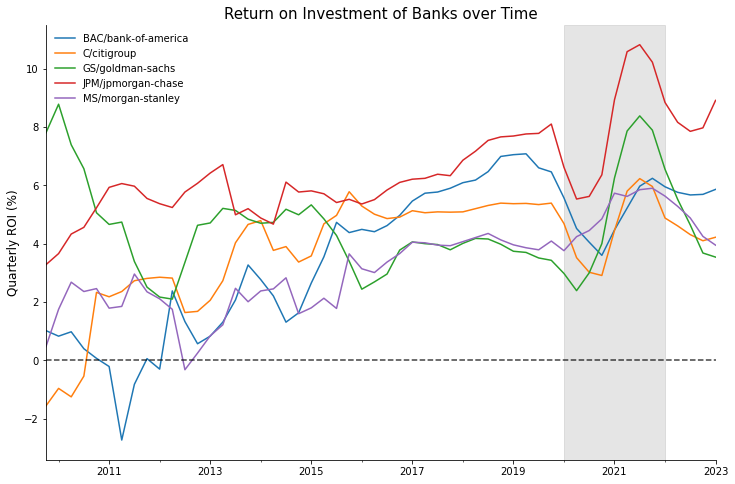

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

roi_pivot.plot(ax=ax)

ax.legend(loc='upper left', frameon=False)

ax.set_xlabel('')
ax.set_ylabel('Quarterly ROI (%)', fontsize=12)
ax.set_title('Return on Investment of Banks over Time', fontsize=15)

ax.axhline(y=0, linestyle='--', color='black', alpha=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvspan('2020-01-01', '2022-01-01', alpha=0.2, color='gray')

plt.show()

In [13]:
# merged df for banks
banking = pd.merge(df_rev, df_roi, how='inner', on=['Date','Bank'])

In [14]:
banking

,Date,Revenue,Bank,TTM Net Income,LT Investments & Debt,ROI
0,2023-03-31,54642.0,JPM/jpmorgan-chase,$52.07B,$598.57B,8.91
1,2022-12-31,47409.0,JPM/jpmorgan-chase,$46.17B,$588.20B,7.97
2,2022-09-30,40809.0,JPM/jpmorgan-chase,$45.59B,$575.49B,7.85
3,2022-06-30,34233.0,JPM/jpmorgan-chase,$47.70B,$574.36B,8.16
4,2022-03-31,32341.0,JPM/jpmorgan-chase,$51.93B,$579.14B,8.84
...,...,...,...,...,...,...
265,2010-12-31,7415.0,MS/morgan-stanley,$6.20B,$257.86B,2.46
266,2010-09-30,6780.0,MS/morgan-stanley,$5.87B,$262.07B,2.36
267,2010-06-30,7963.0,MS/morgan-stanley,$6.56B,$241.97B,2.68
268,2010-03-31,9072.0,MS/morgan-stanley,$4.28B,$244.38B,1.75


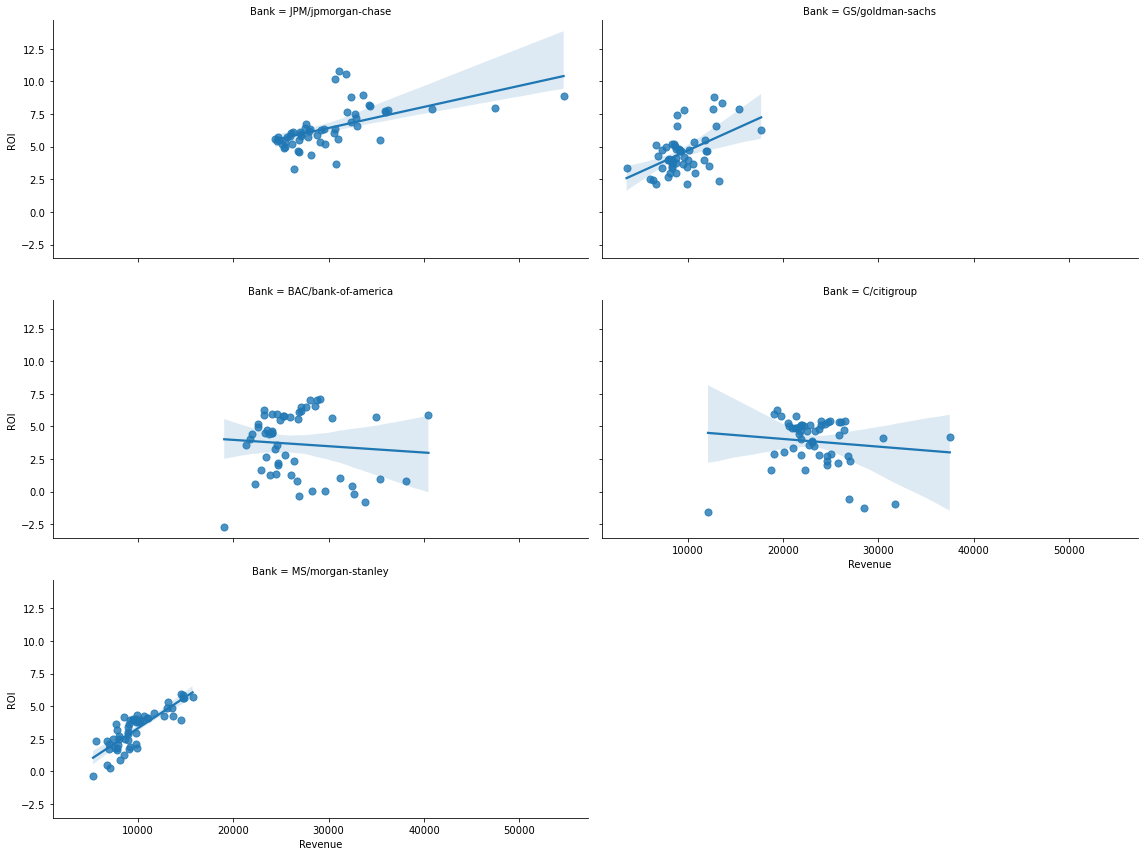

In [15]:
# fig, ax = plt.subplots(1,5, figsize=(12,8))

g = sns.FacetGrid(banking, col="Bank", col_wrap=2, height=4, aspect=2)
g.map(sns.regplot, "Revenue", "ROI", ci=95, scatter_kws={"s": 50})


# ax.set_title('Relationship between ROI and Revenue', fontsize=15)

plt.show()

In [16]:
# sp500 = pd.read_csv('sp500_index.csv')

In [17]:
GDP = web.DataReader('GDPC1', 'fred', start='2010-01-01').dropna().resample('Q').last()

In [18]:
gdp_bank = pd.merge(rev_pivot, GDP, left_index=True, right_index=True, how='inner')

In [19]:
# gdp_bank

In [20]:
# gdp_bank.melt(id_vars='GDPC1', var_name='Bank')

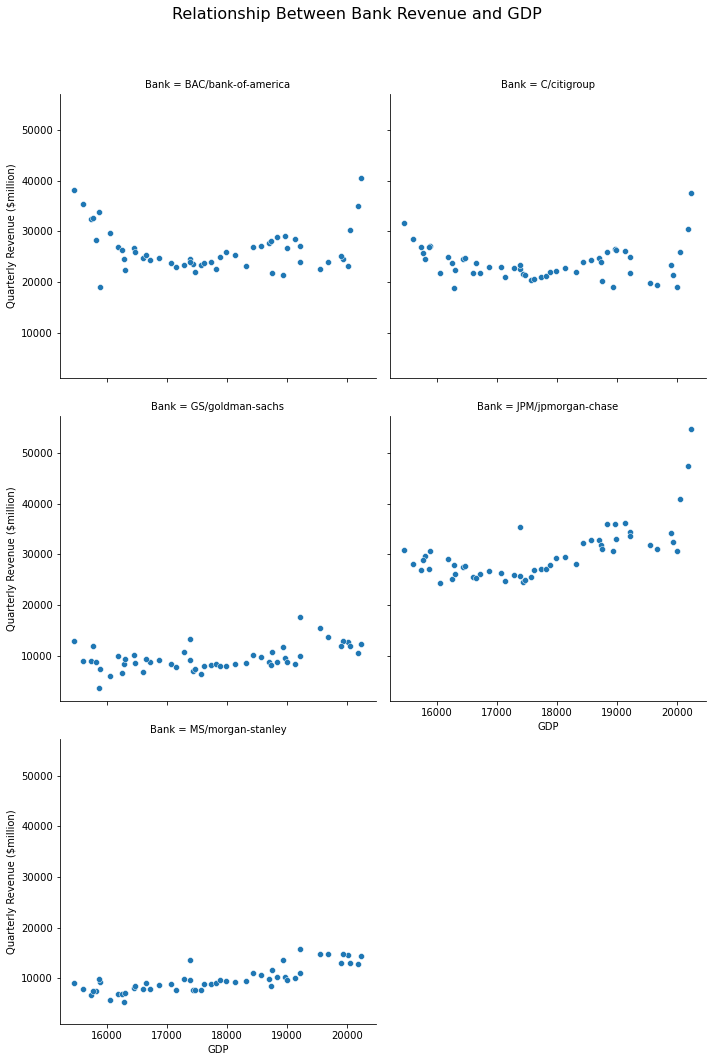

In [21]:
import seaborn as sns

g = sns.relplot(data=gdp_bank.melt(id_vars='GDPC1', var_name='Bank'), x='GDPC1', y='value', col='Bank', col_wrap=2, kind='scatter')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship Between Bank Revenue and GDP', fontsize=16)
g.set_axis_labels('GDP', 'Quarterly Revenue ($million)')